In [35]:
import nibabel as nib
from matplotlib import pyplot as plt
import os
import pickle
import numpy as np

#NN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

# Metrics
from sklearn.metrics import classification_report

# GPU
from tensorflow.python.client import device_lib

In [36]:
# Check GPU Detected
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3115960120372473216
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5090115584
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5136912794137199590
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Functions

In [37]:
def showImage(img, title):
    plt.imshow(img, cmap = "gray", origin = 'upper')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [38]:
def saveModel(directory_name, model, history):
    with open(directory_name + '_History.pkl', 'wb') as file_pi:
        pickle.dump(history, file_pi)

    model.save(directory_name + "_Model.h5")

In [39]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is%20not%20part%20of,each%20epoch,%20need%20to%20make%20some%20more%20efforts.
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [40]:
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [41]:
#https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py
gamma = 2
alpha = .25
def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

## Grouping Files into Datasets

In [42]:
base_path="C:/Users/drago/Documents/gitrepos/individual-project-alzhiemers_detection/MRI Data/WM parc data - cropped images/Blur_Contour_Crop/"

In [43]:
# Break:
# 196 : 97 : 97
# 359 : 178 : 178

In [44]:
# File setup check
print("Total training AD: ", len(os.listdir(base_path+"1-Train/AD")))
print("Total validation AD: ", len(os.listdir(base_path+"2-Validation/AD")))
print("Total testing AD: ", len(os.listdir(base_path+"3-Test/AD")))

print("\nTotal training CN: ", len(os.listdir(base_path+"1-Train/CN")))
print("Total validation CN: ", len(os.listdir(base_path+"2-Validation/CN")))
print("Total testing CN: ", len(os.listdir(base_path+"3-Test/CN")))

Total training AD:  196
Total validation AD:  97
Total testing AD:  97

Total training CN:  359
Total validation CN:  178
Total testing CN:  178


In [71]:
# Build from directory dataset generators
train_aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_aug_datagen = ImageDataGenerator(rescale=1./255)

train_aug_generator = train_aug_datagen.flow_from_directory(
    base_path+"1-Train/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

validation_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

validating_generator = test_aug_datagen.flow_from_directory(
    base_path+"2-Validation/",
    target_size=(256,256),
    batch_size=32,
    shuffle=False,
    class_mode="binary")

test_aug_generator = test_aug_datagen.flow_from_directory(
    base_path+"3-test/",
    target_size=(256,256),
    batch_size=32,
    class_mode="binary")

Found 555 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


### Data Preprosessing

In [46]:
# Check batches shape
for batch, label in train_aug_generator:
    print("data batch shape: ", batch.shape)
    print("label shape: ", label.shape)
    break

data batch shape:  (32, 256, 256, 3)
label shape:  (32,)


## Construct Model

In [33]:
# Construct model
conv_base = VGG16(weights='imagenet',
                 input_shape=(224, 224, 3))

In [34]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
augmentedVGG16 = models.Sequential()
augmentedVGG16.add(conv_base)
augmentedVGG16.add(layers.Flatten())
augmentedVGG16.add(layers.Dense(256, activation='relu'))
augmentedVGG16.add(layers.Dense(1, activation='sigmoid'))
augmentedVGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 23,103,809
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Freeze CNN
conv_base.trainable=False

In [30]:
# Model Compile
augmentedVGG16.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Fitting and Saving Model

In [47]:
base_directory = "Models/VGG16_FocalLoss_Augmented/"

In [32]:
checkpoint = ModelCheckpoint(filepath=base_directory+"checkpoints/best_model.hdf5", save_best_only=True)

# Fit model
VGG16_augmented_history = augmentedVGG16.fit_generator(
    train_aug_generator,
    steps_per_epoch=100,
    epochs=50,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=50)

VGG16_aug_history = VGG16_augmented_history.history

saveModel(base_directory + 'VGG16_focal_aug', augmentedVGG16, VGG16_aug_history)

Epoch 1/50
100/100 [==============================] - 59s 590ms/step - loss: 0.0791 - acc: 0.4899 - precision: 0.7131 - recall: 0.3587 - get_f1: 0.4126 - matthews_correlation: 0.1007 - val_loss: 0.0675 - val_acc: 0.6332 - val_precision: 0.7693 - val_recall: 0.6144 - val_get_f1: 0.6765 - val_matthews_correlation: 0.2769
Epoch 2/50
100/100 [==============================] - 56s 562ms/step - loss: 0.0721 - acc: 0.5221 - precision: 0.7586 - recall: 0.3783 - get_f1: 0.4344 - matthews_correlation: 0.1932 - val_loss: 0.0639 - val_acc: 0.6599 - val_precision: 0.7815 - val_recall: 0.6569 - val_get_f1: 0.7047 - val_matthews_correlation: 0.3024
Epoch 3/50
100/100 [==============================] - 54s 544ms/step - loss: 0.0696 - acc: 0.5221 - precision: 0.7765 - recall: 0.3656 - get_f1: 0.4328 - matthews_correlation: 0.2063 - val_loss: 0.0612 - val_acc: 0.5531 - val_precision: 0.9350 - val_recall: 0.3330 - val_get_f1: 0.4789 - val_matthews_correlation: 0.3234
Epoch 4/50
100/100 [=================

### Retrieving Saved Model and History

In [48]:
# Get history
with open(base_directory + 'VGG16_focal_aug_history.pkl', 'rb') as file__pi:
    VGG16_aug_history = pickle.load(file__pi)
    
# Get best model
VGG16_aug_best = models.load_model(base_directory+"checkpoints/best_model.hdf5", custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})

### Plotting Results

In [35]:
accuracy = VGG16_aug_history['acc']
validation_accuracy = VGG16_aug_history['val_acc']
precision = VGG16_aug_history['precision']
validation_precision = VGG16_aug_history['val_precision']
recall = VGG16_aug_history['recall']
validation_recall = VGG16_aug_history['val_recall']
f1 = VGG16_aug_history['get_f1']
validation_f1 = VGG16_aug_history['val_get_f1']
mcc = VGG16_aug_history['matthews_correlation']
validation_mcc = VGG16_aug_history['val_matthews_correlation']

loss = VGG16_aug_history['loss']
validation_loss = VGG16_aug_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.7843389
train_precision:  0.8634886
train_recall:  0.7914598
train_f1:  0.8223513
train_mcc:  0.55130255
train_loss:  0.05228820145130157

valid_acc:  0.74136806
valid_precision:  0.77603686
valid_recall:  0.8453815
valid_f1:  0.80666786
valid_mcc:  0.42150724
valid_loss:  0.07093672052025796

best_acc:  0.67687297
best_precision:  0.84232366
best_recall:  0.6145308
best_f1:  0.70605314
best_mcc:  0.38181514
best_loss:  0.055435695946216584


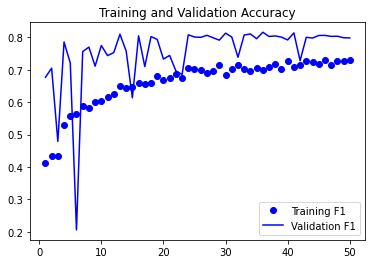

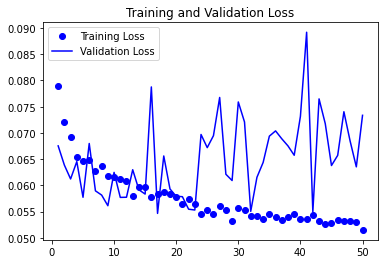

<Figure size 432x288 with 0 Axes>

In [36]:
# Accuracy Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = augmentedVGG16.evaluate_generator(train_aug_generator, steps=50)
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = augmentedVGG16.evaluate_generator(validation_aug_generator, steps=50)
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=50)
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)

## Fine Tune

In [49]:
base_directory = "Models/VGG16_FocalLoss_Augmented_FineTune/"

In [50]:
checkpoint_directory = "checkpoints/"

### Set trainable higher layers

In [39]:
VGG16_aug_best.get_layer(name="vgg16").summary()
vgg16_base = VGG16_aug_best.get_layer(name="vgg16")
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
VGG16_aug_best.get_layer(name="vgg16").summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Compile and fit

In [40]:
# Model Compile
VGG16_aug_best.compile(optimizer=optimizers.RMSprop(lr=1e-5),
                         loss=focal_loss_fixed,
                         metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), get_f1, matthews_correlation])

In [41]:
checkpoint = ModelCheckpoint(filepath=base_directory+checkpoint_directory+"best_model.hdf5", save_best_only=True)

# Fit model
VGG16_history = VGG16_aug_best.fit_generator(
    train_aug_generator,
    steps_per_epoch=18,
    epochs=100,
    callbacks=[checkpoint],
    validation_data=validation_aug_generator,
    validation_steps=30)

VGG16_augmented_fine_tune_history = VGG16_history.history

saveModel(base_directory + 'VGG16_focal_aug_fine_tune', VGG16_aug_best, VGG16_augmented_fine_tune_history)

Epoch 1/100
18/18 [==============================] - 18s 979ms/step - loss: 0.0717 - acc: 0.6595 - precision_1: 0.8484 - recall_1: 0.5766 - get_f1: 0.6295 - matthews_correlation: 0.3931 - val_loss: 0.0543 - val_acc: 0.6982 - val_precision_1: 0.9026 - val_recall_1: 0.5946 - val_get_f1: 0.7125 - val_matthews_correlation: 0.4627
Epoch 2/100
18/18 [==============================] - 13s 727ms/step - loss: 0.0594 - acc: 0.6216 - precision_1: 0.8433 - recall_1: 0.5097 - get_f1: 0.5911 - matthews_correlation: 0.3517 - val_loss: 0.0666 - val_acc: 0.7535 - val_precision_1: 0.7729 - val_recall_1: 0.8821 - val_get_f1: 0.8195 - val_matthews_correlation: 0.4292
Epoch 3/100
18/18 [==============================] - 14s 792ms/step - loss: 0.0586 - acc: 0.6613 - precision_1: 0.8608 - recall_1: 0.5682 - get_f1: 0.6466 - matthews_correlation: 0.4037 - val_loss: 0.0584 - val_acc: 0.6221 - val_precision_1: 0.9692 - val_recall_1: 0.4257 - val_get_f1: 0.5886 - val_matthews_correlation: 0.4295
Epoch 4/100
18/1

Epoch 26/100
18/18 [==============================] - 13s 746ms/step - loss: 0.0514 - acc: 0.6937 - precision_1: 0.8921 - recall_1: 0.5989 - get_f1: 0.7154 - matthews_correlation: 0.5046 - val_loss: 0.0529 - val_acc: 0.7568 - val_precision_1: 0.8312 - val_recall_1: 0.7776 - val_get_f1: 0.8009 - val_matthews_correlation: 0.4834
Epoch 27/100
18/18 [==============================] - 13s 746ms/step - loss: 0.0492 - acc: 0.7189 - precision_1: 0.8830 - recall_1: 0.6518 - get_f1: 0.7347 - matthews_correlation: 0.4952 - val_loss: 0.0564 - val_acc: 0.7731 - val_precision_1: 0.8191 - val_recall_1: 0.8288 - val_get_f1: 0.8252 - val_matthews_correlation: 0.5001
Epoch 28/100
18/18 [==============================] - 13s 745ms/step - loss: 0.0526 - acc: 0.7009 - precision_1: 0.8845 - recall_1: 0.6184 - get_f1: 0.7082 - matthews_correlation: 0.4683 - val_loss: 0.0570 - val_acc: 0.7590 - val_precision_1: 0.8006 - val_recall_1: 0.8331 - val_get_f1: 0.8155 - val_matthews_correlation: 0.4682
Epoch 29/100


Epoch 51/100
18/18 [==============================] - 14s 793ms/step - loss: 0.0418 - acc: 0.7910 - precision_1: 0.9293 - recall_1: 0.7326 - get_f1: 0.8027 - matthews_correlation: 0.6218 - val_loss: 0.0590 - val_acc: 0.7796 - val_precision_1: 0.8204 - val_recall_1: 0.8464 - val_get_f1: 0.8290 - val_matthews_correlation: 0.5029
Epoch 52/100
18/18 [==============================] - 14s 793ms/step - loss: 0.0448 - acc: 0.7586 - precision_1: 0.9121 - recall_1: 0.6936 - get_f1: 0.7807 - matthews_correlation: 0.5621 - val_loss: 0.0894 - val_acc: 0.7600 - val_precision_1: 0.7628 - val_recall_1: 0.9167 - val_get_f1: 0.8304 - val_matthews_correlation: 0.4514
Epoch 53/100
18/18 [==============================] - 14s 794ms/step - loss: 0.0443 - acc: 0.8018 - precision_1: 0.9338 - recall_1: 0.7465 - get_f1: 0.7846 - matthews_correlation: 0.6197 - val_loss: 0.0766 - val_acc: 0.7720 - val_precision_1: 0.7801 - val_recall_1: 0.8986 - val_get_f1: 0.8314 - val_matthews_correlation: 0.4689
Epoch 54/100


Epoch 76/100
18/18 [==============================] - 15s 816ms/step - loss: 0.0352 - acc: 0.8288 - precision_1: 0.9521 - recall_1: 0.7744 - get_f1: 0.8532 - matthews_correlation: 0.6822 - val_loss: 0.0537 - val_acc: 0.7742 - val_precision_1: 0.8579 - val_recall_1: 0.7802 - val_get_f1: 0.8108 - val_matthews_correlation: 0.5197
Epoch 77/100
18/18 [==============================] - 15s 814ms/step - loss: 0.0388 - acc: 0.8072 - precision_1: 0.9468 - recall_1: 0.7437 - get_f1: 0.8253 - matthews_correlation: 0.6453 - val_loss: 0.0728 - val_acc: 0.7959 - val_precision_1: 0.8077 - val_recall_1: 0.9018 - val_get_f1: 0.8508 - val_matthews_correlation: 0.5350
Epoch 78/100
18/18 [==============================] - 15s 814ms/step - loss: 0.0402 - acc: 0.8252 - precision_1: 0.9517 - recall_1: 0.7688 - get_f1: 0.8292 - matthews_correlation: 0.6760 - val_loss: 0.0840 - val_acc: 0.7666 - val_precision_1: 0.7645 - val_recall_1: 0.9186 - val_get_f1: 0.8296 - val_matthews_correlation: 0.4653
Epoch 79/100


### Retrieving Saved Model and History

In [51]:
with open(base_directory + 'VGG16_focal_aug_fine_tune_history.pkl', 'rb') as file__pi:
    VGG16_augmented_fine_tune_history = pickle.load(file__pi)
    
VGG16_augmented_fine_tune_best = models.load_model(base_directory+checkpoint_directory+"best_model.hdf5", 
                                                   custom_objects={"focal_loss_fixed": focal_loss_fixed, "get_f1": get_f1, "matthews_correlation": matthews_correlation})

### Plotting Results

In [52]:
accuracy = VGG16_augmented_fine_tune_history['acc']
validation_accuracy = VGG16_augmented_fine_tune_history['val_acc']
precision = VGG16_augmented_fine_tune_history['precision_1']
validation_precision = VGG16_augmented_fine_tune_history['val_precision_1']
recall = VGG16_augmented_fine_tune_history['recall_1']
validation_recall = VGG16_augmented_fine_tune_history['val_recall_1']
f1 = VGG16_augmented_fine_tune_history['get_f1']
validation_f1 = VGG16_augmented_fine_tune_history['val_get_f1']
mcc = VGG16_augmented_fine_tune_history['matthews_correlation']
validation_mcc = VGG16_augmented_fine_tune_history['val_matthews_correlation']

loss = VGG16_augmented_fine_tune_history['loss']
validation_loss = VGG16_augmented_fine_tune_history['val_loss']

epochs = range(1, len(accuracy) + 1)


train_acc:  0.58203125
train_precision:  0.95454544
train_recall:  0.37724552
train_f1:  0.53862655
train_mcc:  0.37237683
train_loss:  0.05395872425287962

valid_acc:  0.6796875
valid_precision:  0.8429752
valid_recall:  0.6181818
valid_f1:  0.7052991
valid_mcc:  0.38998568
valid_loss:  0.05512391543015838

best_acc:  0.75390625
best_precision:  0.9322034
best_recall:  0.6666667
best_f1:  0.7703179
best_mcc:  0.5527614
best_loss:  0.049233023542910814


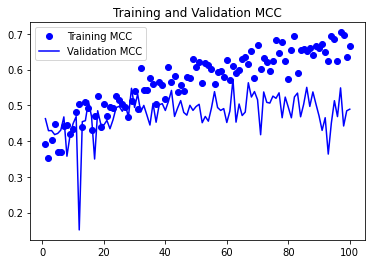

<Figure size 432x288 with 0 Axes>

In [55]:
# MCC Plots
plt.plot(epochs, mcc, 'bo', label='Training MCC')
plt.plot(epochs, validation_mcc, 'b', label='Validation MCC')
plt.title("Training and Validation MCC")
plt.legend()

plt.figure()

# F1 Plots
plt.plot(epochs, f1, 'bo', label='Training F1')
plt.plot(epochs, validation_f1, 'b', label='Validation F1')
plt.title("Training and Validation F1")
plt.legend()

plt.figure()

# Loss Plots
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.figure()

# Generate acc loss percentages
train_loss, train_acc, train_precision, train_recall, train_f1, train_mcc = VGG16_aug_best.evaluate_generator(train_aug_generator, steps=len(train_aug_generator))
print("\ntrain_acc: ", train_acc)
print("train_precision: ", train_precision)
print("train_recall: ", train_recall)
print("train_f1: ", train_f1)
print("train_mcc: ", train_mcc)
print("train_loss: ", train_loss)

# Generate acc loss percentages
valid_loss, valid_acc, valid_precision, valid_recall, valid_f1, valid_mcc = VGG16_aug_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nvalid_acc: ", valid_acc)
print("valid_precision: ", valid_precision)
print("valid_recall: ", valid_recall)
print("valid_f1: ", valid_f1)
print("valid_mcc: ", valid_mcc)
print("valid_loss: ", valid_loss)

# Output best epoch acc loss percentages
best_loss, best_acc, best_precision, best_recall, best_f1, best_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(validation_aug_generator, steps=len(validation_aug_generator))
print("\nbest_acc: ", best_acc)
print("best_precision: ", best_precision)
print("best_recall: ", best_recall)
print("best_f1: ", best_f1)
print("best_mcc: ", best_mcc)
print("best_loss: ", best_loss)

# Output best epoch acc loss percentages
#best_test_loss, best_test_acc, best_test_precision, best_test_recall, best_test_f1, best_test_mcc = VGG16_augmented_fine_tune_best.evaluate_generator(test_aug_generator, steps=len(test_aug_generator))
#print("\nbest_test_acc: ", best_test_acc)
#print("best_test_precision: ", best_test_precision)
#print("best_test_recall: ", best_test_recall)
#print("best_test_f1: ", best_test_f1)
#print("best_test_mcc: ", best_test_mcc)
#print("best_test_loss: ", best_test_loss)

In [112]:
#https://stackoverflow.com/questions/50065484/getting-precision-recall-and-f1-score-per-class-in-keras
# Validation class specific metrics
val_preds = np.round(VGG16_augmented_fine_tune_best.predict_generator(validating_generator),0)
val_trues = validation_aug_generator.classes

classes = np.array(list(validating_generator.class_indices.keys()))

print(classification_report(val_trues, val_preds, target_names = classes))

<class 'numpy.ndarray'>
              precision    recall  f1-score   support

          AD       0.60      0.92      0.72        97
          CN       0.94      0.66      0.78       178

    accuracy                           0.75       275
   macro avg       0.77      0.79      0.75       275
weighted avg       0.82      0.75      0.76       275




Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "C:\Users\drago\anaconda3\Scripts\conda-script.py", line 11, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'



Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "C:\Users\drago\anaconda3\Scripts\conda-script.py", line 11, in <module>
    from conda.cli import main
ModuleNotFoundError: No module named 'conda'
